# 3D MUSIC

### Import Library

In [66]:
import os
import numpy as np
from scipy.constants import c
from matplotlib import pyplot as plt
from pyargus.directionEstimation import *

def normalization(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

def ants_locations():
    return np.array([[-0.0275, -0.0267, 0], # tx
                     [-0.0253, -0.0267, 0],
                     [-0.0231, -0.0267, 0],
                     [-0.0209, -0.0267, 0],
                     [-0.0187, -0.0267, 0],
                     [-0.0165, -0.0267, 0],
                     [-0.0143, -0.0267, 0],
                     [-0.0122, -0.0267, 0],
                     [-0.0100, -0.0267, 0],
                     [-0.0078, -0.0267, 0],
                     [-0.0056, -0.0267, 0],
                     [-0.0034, -0.0267, 0],
                     [-0.0012, -0.0267, 0],
                     [ 0.0009, -0.0267, 0],
                     [ 0.0031, -0.0267, 0],
                     [ 0.0053, -0.0267, 0],
                     [ 0.0075, -0.0267, 0],
                     [ 0.0097, -0.0267, 0],
                     [ 0.0119, -0.0267, 0],
                     [ 0.0141, -0.0267, 0],
                     [ 0.0274, -0.0133, 0], # rx
                     [ 0.0274, -0.0112, 0],
                     [ 0.0274, -0.0091, 0],
                     [ 0.0274, -0.0070, 0],
                     [ 0.0274, -0.0049, 0],
                     [ 0.0274, -0.0028, 0],
                     [ 0.0274, -0.0007, 0],
                     [ 0.0275,  0.0014, 0],
                     [ 0.0275,  0.0035, 0],
                     [ 0.0275,  0.0056, 0],
                     [ 0.0275,  0.0078, 0],
                     [ 0.0275,  0.0099, 0],
                     [ 0.0275,  0.0120, 0],
                     [ 0.0274,  0.0141, 0],
                     [ 0.0274,  0.0162, 0],
                     [ 0.0275,  0.0183, 0],
                     [ 0.0275,  0.0204, 0],
                     [ 0.0275,  0.0225, 0],
                     [ 0.0275,  0.0246, 0],
                     [ 0.0275,  0.0267, 0]])

### Define Parameters & Load Data

In [72]:
data_root = '/Users/seanyao/Library/CloudStorage/Box-Box/Vayyar Radar/' #Change to your local path
cur_case = 'vital_signs_infant_914'
cur_scenario = '50k_profile_2_gt_30pm_degree_0'

num_tx = 20
rbw = 100

tx_arr = ants_locations()[:20,0] - ants_locations()[0,0]
rx_arr = ants_locations()[20:,1] - ants_locations()[20,1]

# num_tx = 20
# rbw = 10
data_path = os.path.join(data_root, cur_case, cur_scenario)
recording = np.load(os.path.join(data_path, "recording.npy"))
# calibration = np.load(os.path.join(data_path, "calibration.npy"))
config = np.load(os.path.join(data_path, "config.npy"), allow_pickle=True).item()
print(config.keys())
doppler_nfft = recording.shape[0]
range_nfft = 512
angle_nfft = [10, 10]
data_arr = recording

dict_keys(['start_freq', 'stop_freq', 'n_freq', 'rbw', 'scan_profile', 'txRxPairs', 'freq', 'nfft', 'dist_vec', 'collect_time', 'sample_time'])


## 3D FFT

In [73]:
# Processing
processed_data = data_arr - np.mean(data_arr[:2,:,:], axis=0)
range_profile = np.fft.ifft(processed_data, n=range_nfft, axis=2)

print(data_arr.shape)

processed_data_3d = processed_data.reshape(processed_data.shape[0], num_tx, 20, processed_data.shape[-1])
processed_data_3d_range = np.fft.ifft(processed_data_3d, n=range_nfft, axis=3)
processed_data_3d_range = np.fft.fft2(processed_data_3d_range, s=angle_nfft, axes=(1, 2))

(200, 400, 150)


In [74]:
# Plot
for i in range(angle_nfft[0]):
    for j in range(angle_nfft[1]):
        value = processed_data_3d_range[:, i, j, :]
        doppler = np.fft.fft(np.real(value), n=doppler_nfft, axis=0)
        doppler_slide = doppler[0:len(doppler)//2,:]
        doppler_slide = np.abs(doppler_slide.T)

        freq = config['freq']
        Ts = 1/range_nfft/(freq[1]-freq[0]+1e-16) # Avoid nan checks
        time_vec = np.linspace(0,Ts*(range_nfft-1),num=range_nfft)
        dist_vec = time_vec*(c/2) # distance in meters

        d = config["sample_time"]
        pulse_repetition_frequency = 1/d
        # print("d", d)
        doppler_freq = np.fft.fftfreq(doppler_nfft,d)
        doppler_freq = doppler_freq[doppler_freq>=0]

        # plt.figure(figsize=(8,6))
        # freq_low = np.where(doppler_freq>=0.1)[0][0]
        # freq_high = np.where(doppler_freq<=2.0)[0][-1]
        # range_low = np.where(dist_vec>=0.13)[0][0]
        # range_high = np.where(dist_vec<=2)[0][-1]

        # extent=[doppler_freq[freq_low],doppler_freq[freq_high],dist_vec[range_low],dist_vec[range_high]]
        # plt.imshow((doppler_slide[range_low:range_high, freq_low:freq_high]), origin='lower', extent=extent, aspect='auto')
        # # plt.legend()
        # plt.colorbar()
        # plt.xlabel("Doppler Frequency [Hz]")
        # plt.ylabel("Range [m]")
        # plt.title(f"{i}{j}Range-Doppler Vital Sign Heatmap: {num_tx} Tx {rbw} [Hz]")
        # plt.grid()
        # plt.show()

## MUSIC

### ToF MUSIC

In [80]:
# Function Declaration

def compute_tof_scanning_vector(freq, time_vec):
    # Compute the scanning vector
    df = freq[1] - freq[0]
    freq_shift = np.arange(0,len(freq))
    freq_shift =  df*freq_shift
    scanning_vectors = np.zeros((len(freq),len(time_vec)),dtype='complex')
    for i in range(len(time_vec)):
        scanning_vectors[:,i] = np.exp(-1j*2*np.pi*freq_shift*time_vec[i])
    # scanning_vectors = np.real(scanning_vectors)
    # scanning_vectors = np.exp(1j*2*np.pi*time_vec).reshape(-1,1)
    return scanning_vectors


def compute_tof_music(test_signal, scanning_vectors, dist_vec, signal_dimension=3, plot=False):
    # test_signal = test_signal.reshape(-1,1)

    # Compute the correlation matrix
    # R = np.dot(test_signal, test_signal.conj().T)
    P = 150
    R = spatial_smoothing(test_signal, P=P, direction="forward-backward")

    # Implement MUSIC for ToF
    tof = np.zeros(np.size(scanning_vectors, 1))
    M = np.size(R, 0)

    # --- Calculation ---
    # Determine eigenvectors and eigenvalues
    sigmai, vi = lin.eig(R)
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)

    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        tof[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1

    log_scale_min = -50

    tof = np.divide(np.abs(tof),np.max(np.abs(tof))) # normalization 
    tof = 10*np.log10(tof)                
    time_index = 0        
    for t in time_vec:                    
        if tof[time_index] < log_scale_min:
            tof[time_index] = log_scale_min
        time_index += 1   
    # tof = normalization(np.abs(tof))
    tof = normalization(tof-np.min(tof))
    if plot:
        plt.figure()
        axes = plt.axes()
        axes.plot(dist_vec,tof)    
        axes.set_title('ToF MUSIC estimation ',fontsize = 16)
        axes.set_xlabel('Range [m]')
        axes.set_ylabel('Amplitude [dB]')   
        axes.legend(["MUSIC"])
    # print(tof)
    return tof

# Compute dist_vec
Ts = 1/len(config['freq'])/(config['freq'][1]-config['freq'][0]+1e-16)
time_vec = np.linspace(0,Ts*(len(config['freq'])-1),num=len(config['freq']))
dist_vec = time_vec*(c/2)

(400, 150)
3.0417513674196064


In [ ]:
print(config.keys())

dict_keys(['start_freq', 'stop_freq', 'n_freq', 'rbw', 'scan_profile', 'txRxPairs', 'freq', 'nfft', 'dist_vec', 'collect_time', 'sample_time'])


Text(0, 0.5, 'Magnitude')

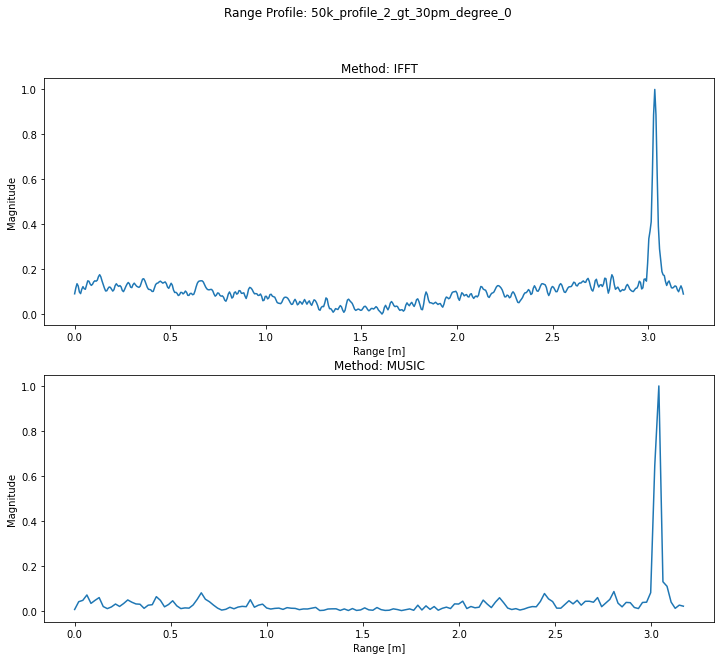

In [83]:
range_profile_ifft = np.fft.ifft(processed_data[100],n=range_nfft,axis=1)

range_profile_ifft = normalization(np.linalg.norm(range_profile_ifft,axis=0))
# range_profile_ifft[config['dist_vec']>2.5] = 0


test_signal = processed_data[100,:,:] #- cal_arr
scanning_vectors = compute_tof_scanning_vector(config['freq'],time_vec)
range_profile_music = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, dist_vec=dist_vec, signal_dimension=6,plot=False)

fig, axs = plt.subplots(2,figsize=(12,10))
fig.suptitle(f'Range Profile: {cur_scenario}')
axs[0].plot(config['dist_vec'],range_profile_ifft)
axs[0].set_title('Method: IFFT')
axs[0].set_xlabel('Range [m]')
axs[0].set_ylabel('Magnitude')
axs[1].plot(dist_vec,range_profile_music)
axs[1].set_title('Method: MUSIC')
axs[1].set_xlabel('Range [m]')
axs[1].set_ylabel('Magnitude')

### AoA / AoD MUSIC

In [ ]:
# Function Declaration

def compute_aoa_aod_scanning_vector(array_alignment, thetas):
    # Compute the scanning vector
    df = freq[1] - freq[0]
    scanning_vectors = np.zeros((len(array_alignment),len(thetas)),dtype='complex')
    for i in range(len(thetas)):
        scanning_vectors[:,i] = np.exp(-1j*2*np.pi*array_alignment*np.cos(np.radians(thetas[i])))
    # scanning_vectors = np.real(scanning_vectors)
    # scanning_vectors = np.exp(1j*2*np.pi*time_vec).reshape(-1,1)
    return scanning_vectors


def compute_aoa_music(test_signal, scanning_vectors, thetas, signal_dimension=3, P=150, plot=False):
    # test_signal = test_signal.reshape(-1,1)

    # Compute the correlation matrix
    # R = np.dot(test_signal, test_signal.conj().T)
    R = spatial_smoothing(test_signal, P=P, direction="forward-backward")

    # Implement MUSIC for ToF
    aoa = np.zeros(np.size(scanning_vectors, 1))
    M = np.size(R, 0)

    # --- Calculation ---
    # Determine eigenvectors and eigenvalues
    sigmai, vi = lin.eig(R)
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)

    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        tof[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1

    log_scale_min = -50

    tof = np.divide(np.abs(tof),np.max(np.abs(tof))) # normalization 
    tof = 10*np.log10(tof)                
    time_index = 0        
    for t in time_vec:                    
        if tof[time_index] < log_scale_min:
            tof[time_index] = log_scale_min
        time_index += 1   
    # tof = normalization(np.abs(tof))
    tof = normalization(tof-np.min(tof))
    if plot:
        plt.figure()
        axes = plt.axes()
        axes.plot(thetas,tof)    
        axes.set_title('AoA/AoD MUSIC estimation ',fontsize = 16)
        axes.set_xlabel('Angle [deg]')
        axes.set_ylabel('Amplitude [dB]')   
        axes.legend(["MUSIC"])
    # print(tof)
    return tof

# Extract the data of the first TxRx pair in the first frame
test_signal = data_arr[100,:,:]#-cal_arr
test_signal = test_signal#[10,:]
Ts = 1/len(config['freq'])/(config['freq'][1]-config['freq'][0]+1e-16)
time_vec = np.linspace(0,Ts*(len(config['freq'])-1),num=len(config['freq']))
dist_vec = time_vec*(c/2)
scanning_vectors = compute_tof_scanning_vector(config['freq'],time_vec)
test_tof = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, dist_vec=dist_vec, signal_dimension=10,plot=False)
print(dist_vec[np.argmax(test_tof)])